# Exploring ODF Extraction
## Sam Potter
## Current: 3/18/19

## Path and Imports

In [1]:
import sys
import os

sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
from dic import visualize
from dic import fileIO
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import rc
from dic import utilities

from ipywidgets import *
from scipy import optimize as sciopt

## Magics

In [2]:
%matplotlib inline

## Optical Mathematics

### Cylindrical scattering for single fiber

$I_{fiber}(\theta) = a_0 + a_2 \cos(2(\theta - \phi)) + a_4 \cos(4(\theta - \phi))$

### Cylindrical scattering for a distribution of fibers

$I_{dist}(\theta) = \int_{-\pi/2}^{\pi/2} I_{fiber}(\theta) PDF_{dist}(\theta) d \theta$

## Setup Single Fiber Cosine Series

### Definition of single fiber function

In [3]:
def Ifiber(a0, a2, a4, phi, numpts=100):
    
    theta = np.linspace(-90, 90, numpts)
    
    vals = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    nvals = utilities.normalize_1d(vals)
    
    return nvals, theta

In [4]:
def Ifiber_interactive(a0, a2, a4, phi, numpts=100):
    
    theta = np.linspace(-90, 90, numpts)
    
    vals = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    nvals = utilities.normalize_1d(vals)
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(theta, nvals, color='g', label='Intensity');
    plt.legend(prop={'size': 18});
    plt.xlabel(r'$\theta$', fontsize=18);
    plt.ylabel('Normalized Intensity (a.u.)', fontsize=18);
    plt.title('Normalized Intensity Curves of Single Fiber under Cylindrical Scattering', fontsize=18);
    plt.autoscale(enable=True, axis='x', tight=True)
    
    print('a2/a4: {}'.format(a2/a4))

### Ranges of a0, a2, a4

In [5]:
a0 = np.linspace(0, 1, 10)
a2 = np.linspace(0, 0.05, 10)
a4 = np.linspace(0, 0.2, 10)

### Plot a sample intensity function

In [6]:
p = interactive(Ifiber_interactive, a0=(0, 1, 0.1), a2=(0, 0.05, 0.005), a4=(0, 0.2, 0.02), phi=(-90, 90, 5), numpts=(100, 500, 10))
display(p)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0), FloatSlider(value=0.025, description=…

## Setup Gaussian Distribution

### Setup and generate samples

In [7]:
def syntheticIdist(a0, a2, a4, mu, sigma, nsamples):
    
    samples = np.random.normal(mu, sigma, nsamples)
    ntheta = 100
    Idist = np.zeros((len(samples), ntheta))
    for i in range(0, len(samples)):
        vals, theta_dist = Ifiber(a0, a2, a4, samples[i], numpts=ntheta)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0)
    Idist = utilities.normalize_1d(Idist)
    
    return Idist

In [8]:
def compareI(a0, a2, a4, phi0, mu, sigma, nsamples):
    
    samples = np.random.normal(mu, sigma, nsamples)
    ntheta = 100
    Idist = np.zeros((len(samples), ntheta))
    for i in range(0, len(samples)):
        vals, theta_dist = Ifiber(a0, a2, a4, samples[i], numpts=ntheta)
        Idist[i, :] = vals

    Idist = np.sum(Idist, axis=0)
    Idist = utilities.normalize_1d(Idist)
    
    Ifibers, theta_fiber = Ifiber(a0, a2, a4, phi0, numpts=ntheta)
    
    fig = plt.figure(figsize=(8, 8))
    plt.plot(theta_fiber, Ifibers, color='g', label='Single Fiber Intensity');
    plt.plot(theta_dist, Idist, color='r', label='Fiber Distribution Intensity');
    plt.legend(prop={'size': 18}, loc='best');
    plt.xlabel(r'$\theta$', fontsize=18);
    plt.ylabel('Intensity (a.u.)', fontsize=18);
    plt.title('Intensity Curves from Single Fiber and a Distribution of Fibers', fontsize=18);
    plt.ylim(0, 1.25)
    plt.autoscale(enable=True, axis='x', tight=True)
    

In [9]:
p = interactive(compareI, a0=(0, 1, 0.1), a2=(0, 0.05, 0.005), a4=(0, 0.2, 0.02), phi0=(-90, 90, 5), mu=(-1, 1, 0.5), sigma=(0, 90, 5), nsamples=(10, 1000, 10))
display(p)

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0), FloatSlider(value=0.025, description=…

## See if I can fit the new a0, a2, and a4 terms from the Idist

In [10]:
def minimand(a0, a2, a4, phi, data):
    
    theta = np.linspace(-90, 90, len(data))
    
    feval = a0 + a2 * np.cos(np.deg2rad(2 * (theta - phi))) + a4 * np.cos(np.deg2rad(4 * (theta - phi)))
    
    diff = data - feval
    
    diffsq = np.square(diff, diff)
    
    ssd = np.sum(diffsq)
    
    return ssd

In [11]:
def minfun(params, *args):

    return minimand(params[0], params[1], params[2], params[3], *args)

In [35]:
Idist_data = syntheticIdist(0, 0.0652, 0.2489, 0, 10, 1000)
minimand(.6, 0.025, .1, 45, Idist_data)

17.60222366855238

## Find the distribution terms

In [36]:
args_tup = (Idist_data)
int_x = np.array([.6, 0.025, .15, 45])
bounds = ((0, 1), (-1, 1), (0, 1), (0, 180))
res = sciopt.minimize(minfun, int_x, args=args_tup, bounds=bounds, method='L-BFGS-B', jac='2-point')
#res = sciopt.minimize(minfun, int_x, args=args_tup, method='Nelder-Mead')

In [37]:
print('Final values of a0, a2, a4, phi: {}'.format(res.x))
print('Final residual: {}'.format(res.fun))

Final values of a0, a2, a4, phi: [ 4.38814292e-01 -9.83446857e-04  0.00000000e+00  4.49999681e+01]
Final residual: 10.171380871777844


## Sample a2 and a4 from Will Goth

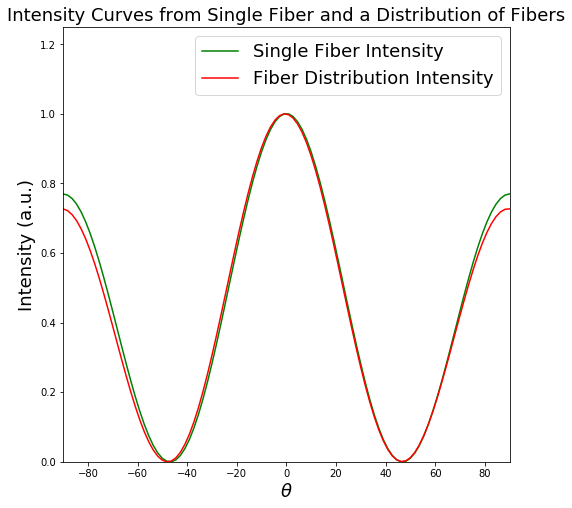

In [34]:
intensityf, theta = Ifiber(0, 0.0652, 0.2489, 0)
intensitydist = syntheticIdist(0, 0.0652, 0.2489, 0, 10, 1000)

fig = plt.figure(figsize=(8, 8))
plt.plot(theta, intensityf, color='g', label='Single Fiber Intensity');
plt.plot(theta, intensitydist, color='r', label='Fiber Distribution Intensity');
plt.legend(prop={'size': 18}, loc='best');
plt.xlabel(r'$\theta$', fontsize=18);
plt.ylabel('Intensity (a.u.)', fontsize=18);
plt.title('Intensity Curves from Single Fiber and a Distribution of Fibers', fontsize=18);
plt.ylim(0, 1.25)
plt.autoscale(enable=True, axis='x', tight=True)

### Analytical distribution

In [15]:
def gauss(mu, sigma, x):
    
    val = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    
    return val